In [68]:
import numpy as np
import scipy.signal
from collections import namedtuple

def get_time(duration, dt, sym=True):
    """
    Make a time vector.

    If `sym` is `True`, the time vector will have an odd number of samples,
    and will be symmetric about 0. If it's False, and the number of samples
    is even (e.g. duration = 0.016, dt = 0.004), then 0 will bot be center.
    """
    # This business is to avoid some of the issues with `np.arange`:
    # (1) unpredictable length and (2) floating point weirdness, like
    # 1.234e-17 instead of 0. Not using `linspace` because figuring out
    # the length and offset gave me even more of a headache than this.
    n = int(duration / dt)
    odd = n % 2
    k = int(10**-np.floor(np.log10(dt)))
    dti = int(k * dt)  # integer dt

    if (odd and sym):
        t = np.arange(n)
    elif (not odd and sym):
        t = np.arange(n + 1)
    elif (odd and not sym):
        t = np.arange(n)
    elif (not odd and not sym):
        t = np.arange(n) - 1

    t -= t[-1] // 2

    return dti * t / k
    
def klauder(duration, dt, f):
    """
    Makes a Klauder wavelet. f is a 2-tuple.
    """
    # Make a time basis, t0 (srtart) and t1 (emd).
    t = get_time(duration, dt)
    t0, t1 = t[0], t[-1]

    # Make f0 and f1.
    try:
        f_, f1 = f
    except (AttributeError, ValueError) as e:
        raise ValueError('f should be a 2-tuple')
    f0, f1 = f

    # Create a shirp.
    c = scipy.signal.chirp(t, f0, t1, f1)

    # Correlate chirp with self.
    w = np.correlate(c, c)

    # Normalize the amplitude.
    w /= np.amax(w)

    return {'wavelet': w, 'time': t}

# We want to call the function like this:
w, t = klauder(0.300, 0.001, (3, 80))

In [69]:
# We want to call the function like this:
w, t = klauder(0.300, 0.001, (23, 24, 25, ))

ValueError: f should be a 2-tuple

In [61]:
f1, f2 = (23, 24, 25, )

ValueError: too many values to unpack (expected 2)

ValueError: 'wavelet' is not a valid format string (unrecognized character 'a')

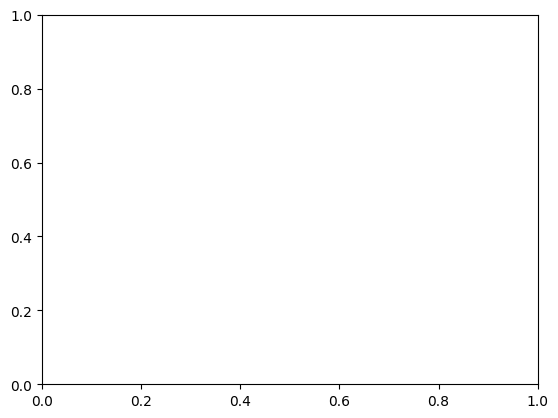

In [55]:
plt.plot(t, w)

# 𝔸𝕀 𝕚𝕞𝕒𝕘𝕖 𝕒𝕟𝕒𝕝𝕪𝕤𝕚𝕤 𝕗𝕠𝕣 𝕘𝕖𝕠𝕤𝕔𝕚𝕖𝕟𝕔𝕖

Let's test multi-modal LLMs with some questions about images.

This notebook asks scientific questions about geological and geophysical images. We focus on zero-shot questions for now, with almost all the context coming from the image (and a very small amount from the questions). This is perhaps the least fair approach, but I think it's a good way to get a feel for the 'out of the box' capability of the models.

---

## Set up chatbots

We will make some functions for talking to the various services:

- ChatGPT 4o
- Claude 3.5 Sonnet
- Gemini 1.5 Pro

In [1]:
# See https://platform.openai.com/docs/quickstart
from dotenv import load_dotenv
import google.generativeai as goog
import os

__ = load_dotenv(".env") # If key is in a file.
# OpenAI and Anthropic read keys right from env.
goog.configure(api_key=os.environ["GEMINI_API_KEY"])

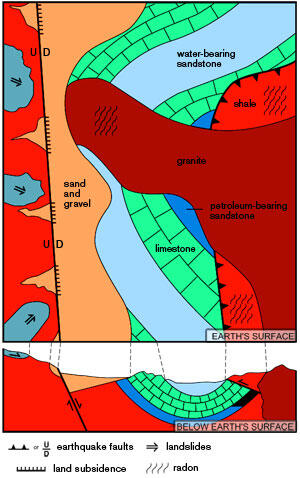

In [2]:
from IPython.display import Image

image_url = "https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/sollerfig1.jpg"
Image(image_url)

## OpenAI's ChatGPT

In [3]:
import httpx
import base64
from openai import OpenAI

def ask_chatgpt(prompt, image_url=None, image_format='jpeg'):
    """Ask ChatGPT about an (optional) image."""
    content = []
    if image_url is not None:
        image_media_type = f"image/{image_format}"
        image = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
        image_content = {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{image}"}
            }
        content.append(image_content)
    content.append({"type": "text", "text": prompt})
    messages = [{"role": "user", "content": content}]
    completion = OpenAI().chat.completions.create(
        model="gpt-4o",
        temperature=0.5,
        messages=messages
    )
    response = completion.choices[0].message
    return f'**ChatGPT**<br/><hr/>{response.content}'

In [4]:
from IPython.display import Markdown

q = "Describe this image. Be brief."

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>The image is a geological cross-section diagram illustrating various layers and features beneath the Earth's surface. It shows earthquake faults, landslides, land subsidence, and radon presence. The diagram includes different rock types such as sand and gravel, granite, shale, limestone, and petroleum-bearing sandstone, as well as water-bearing sandstone. The faults are marked with "U" (up) and "D" (down) to indicate movement directions.

## Anthropic's Claude

In [5]:
from anthropic import Anthropic

def ask_claude(prompt, image_url=None, image_format='jpeg'):
    """Ask Claude about an image."""
    content = []
    if image_url is not None:
        image_media_type = f"image/{image_format}"
        image = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
        image_content = {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": image_media_type,
                "data": image,
            },
        }
        content.append(image_content)
    content.append({"type": "text", "text": prompt})
    completion = Anthropic().messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1024,
        messages=[{"role": "user", "content": content}],
    )
    response = completion.content[0]
    return f'**Claude**<br/><hr/>{response.text}'

Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>This image is a geological cross-section diagram showing different layers and types of rock formations both above and below the Earth's surface. It uses various colors to represent different geological features such as water-bearing sandstone (green), shale (red), granite (dark red), limestone (light blue), and sand and gravel (orange). The diagram also indicates earthquake faults, landslides, and areas of land subsidence. It's divided into two main sections: "Earth's surface" and "Below Earth's surface," providing a visual representation of underground geological structures and potential hazards.

## Google's Gemini

In [6]:
def ask_gemini(prompt, image_url=None, image_format='jpeg'):
    """Ask Google Gemini"""
    content = []
    if image_url is not None:
        with open('tmp', 'wb') as f:
            f.write(httpx.get(image_url).content)
        myfile = goog.upload_file('tmp',
                                  mime_type=f'image/{image_format}')
        content.append(myfile)

    # Call the API.
    model = goog.GenerativeModel("gemini-1.5-pro")  # or -pro
    content.extend(["\n\n", prompt])
    response = model.generate_content(content)
    return f'**Gemini**<br/><hr/>{response.text}'

Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>The diagram illustrates a geological cross-section showcasing different rock layers and potential hazards associated with them. Above the surface, various rock types like sandstone, limestone, and granite are visible, some bearing water or petroleum.  Below the surface, a fault line is prominent, indicating risks of earthquakes, landslides, land subsidence, and radon gas presence. 


#### End of setup

---
# Asking questions about images

There are several kinds of questions we might like to ask:

- Recover text or numbers from the image, eg to read a document or sign in an image
- Texture and object recognition
- Segmentation, eg for analysis of proportional area
- Measurements from the image, eg of objects or the space between them
- ❗ Descriptions of the content, eg to help make sense of a document or prepare a searchable index
- ❗ Questions about the content, eg to learn something about the image that might not be in a description
- ❗ Questions about what the content implies about the past, eg because the image can be interpreted by someone with insight
- ❗ Questions about what the content implies about the future, eg because of cause and effect
- ...and so on

All of these tasks are quite hard, but those with ❗ were extremely hard to do before multi-modal generative AI models came along. 


# Map and cross-section

[The image](https://www.usgs.gov/media/images/typical-geologic-map) is from the USGS and is public domain.

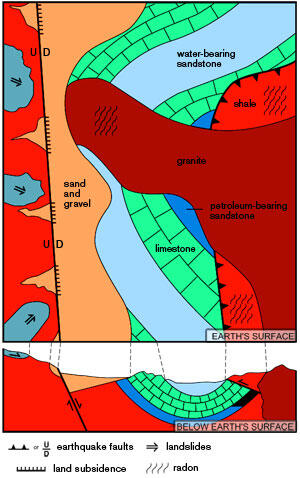

In [7]:
from IPython.display import Image

image_url = "https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/sollerfig1.jpg"
Image(image_url)

In [8]:
q = ("Which is younger, the limestone or the shale? "
     "Give your reason but be brief.")
     # Limestone.

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>The shale is younger than the limestone. This is evident because the shale layer is positioned above the limestone layer in the stratigraphic sequence, indicating that it was deposited after the limestone.

In [9]:
Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>Based on the diagram, the shale appears to be younger than the limestone. The reason for this is the principle of superposition in geology, which states that in undisturbed rock layers, the younger layers are deposited on top of older layers. In this image, we can see that the shale layer is positioned above the limestone layer, indicating it was deposited later and is therefore younger.

In [10]:
Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>The limestone is younger. Sedimentary rocks are deposited with the youngest on top, so since the limestone is above the shale, it is younger. 


# Seismic section

The image is from the [Sub-Surf Rocks blog](http://sub-surfrocks.co.uk/?page_id=197) at the University of Derby, who have licensed it from the UK Onshore Geophysical Library. The license terms are not clear, but [the UKOGL](https://ukogl.org.uk/) calls the image 'free'.

This is the Weald Anticline, a reactivated rift.

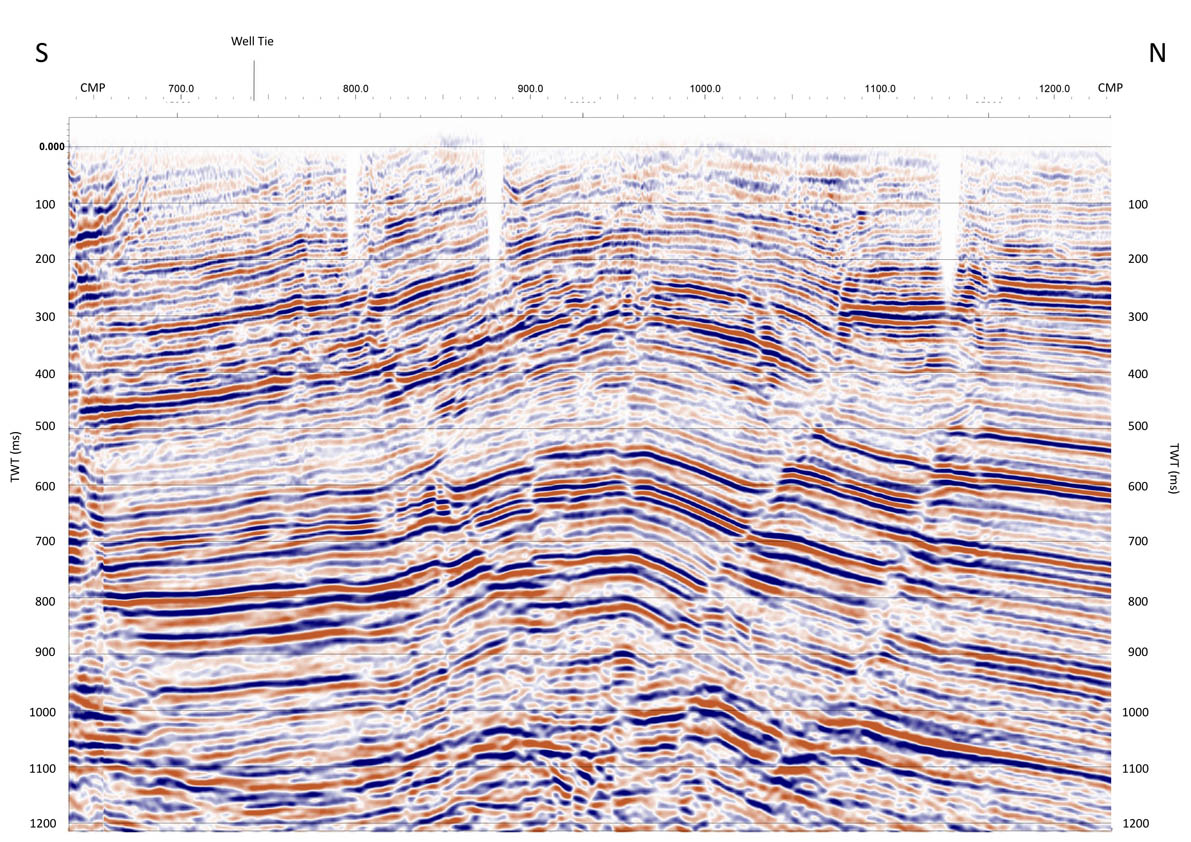

In [11]:
image_url = "http://www.sub-surfrocks.co.uk/wp-content/uploads/2015/06/seismic_a3_colour.jpg"
Image(image_url)

In [12]:
q = ("Describe the structural geology. "
     "Explain your reasoning but be brief.")
     # Rift reactivation.

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>The seismic section shows a complex structural geology characterized by folded and faulted sedimentary layers. 

1. **Folding:**
   - The seismic reflectors exhibit undulating patterns indicating the presence of folds. These folds are likely anticlines and synclines, as seen by the alternating crests and troughs of the seismic reflectors.

2. **Faulting:**
   - Several vertical to sub-vertical discontinuities cut across the seismic reflectors, indicating the presence of faults. These faults disrupt the continuity of the layers, suggesting normal faulting due to extensional tectonics.

3. **Layered Stratigraphy:**
   - The reflectors are generally continuous and parallel, suggesting layered sedimentary sequences. The variation in reflector amplitude and spacing indicates changes in lithology and depositional environments.

4. **Depth and Time:**
   - The vertical axis represents two-way travel time (TWT) in milliseconds, with deeper layers corresponding to higher TWT values.

In summary, the seismic section reveals a region influenced by both folding and faulting, indicative of a tectonically active area with significant structural deformation.

In [13]:
Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>This image shows a seismic reflection profile, which is used to image subsurface geology. The structural geology visible here indicates:

1. Sedimentary layers: The horizontal banding represents layers of sedimentary rocks.

2. Folding: There are gentle undulations in the layers, particularly visible in the middle and lower sections, suggesting folding of the strata.

3. Faulting: Sharp discontinuities in the layers, especially noticeable around the 800 CMP mark, indicate the presence of faults.

4. Anticlines and synclines: The upward and downward curves in the layers represent anticlines (upward folds) and synclines (downward folds).

5. Possible unconformities: Some areas show truncation of layers, which could indicate erosional surfaces or unconformities.

The reasoning for these interpretations comes from the patterns of reflectors (the colored bands) in the seismic image. Their continuity, discontinuity, and geometric relationships reveal the underlying geological structures and deformation history of the area. The varying intensity of the reflectors also suggests changes in rock properties or lithology across the imaged section.

In [14]:
Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>The seismic section shows a **dipping reflector pattern**.  

* **Reasoning:** The reflectors, representing geological boundaries, are consistently sloping downwards from left to right. This consistent slope indicates a dipping geological structure. 

* **Possible Interpretation:** This pattern is often associated with tilted layers or a fault block that has been rotated during tectonic activity. Without further information or context, it's impossible to definitively determine the specific structure. 


# Core photo

The image is from [REP Austria's website](https://www.rep-austria.at/en/services-expertise/geologie/reservoir-characterisation-formation-evaluation.html) and is used here under the fair use doctrine.

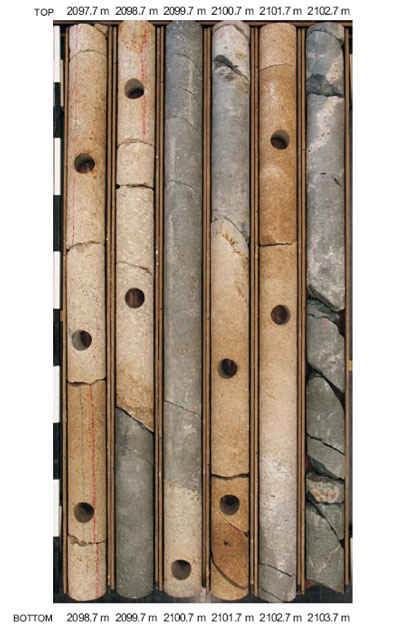

In [15]:
image_url = "https://www.rep-austria.at/fileadmin/bilder/Archiv/geschaeftsbereiche/2_1_suchen/2_1_2_geologie/2_1_2_3_lagerstaettenbewertung/2_1_2_3_bohrkern.jpg"
Image(image_url)

In [16]:
q = ("How much core is there here?"
     "Explain your reasoning but be brief.")
     # 

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>The core sample in the image spans from a depth of 2097.7 meters to 2103.7 meters. To determine the length of the core, we subtract the starting depth from the ending depth:

2103.7 meters - 2097.7 meters = 6.0 meters

Therefore, there is 6.0 meters of core sample in the image.

In [17]:
Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>This image shows approximately 5 meters of core samples. 

My reasoning:
1. The image displays cylindrical rock core samples arranged vertically.
2. There's a scale at the top and bottom of the image showing depths.
3. The scale ranges from about 2097.7m at the top to about 2102.7m at the bottom.
4. The difference between these depths is roughly 5 meters.

Therefore, this image represents about 5 meters of core samples extracted from a drilled hole, likely for geological analysis or exploration purposes.

In [18]:
Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>There is approximately 3.0 meters of core. 

The top labels range from 2097.7m to 2102.7m (a 5m difference). However, the bottom labels show the last core beginning at 2103.7m. This means the total core length displayed is a bit less than the 5m difference between the highest and lowest depth labels.  Since core sections are typically around 1 meter, and these appear to be full or near-full sections, an estimate of 3.0 meters is reasonable. 


# Block diagram: spatio-temporal reasoning

This image is from [Robert S Leighty's Geology 101 course](https://physci.mesacc.edu/Geology/Leighty/GLG101IN/GLG101IN_Lab03_GeologicMaps/GLG101IN_Lab03_GeologicMaps5.html) at Mesa Community College.

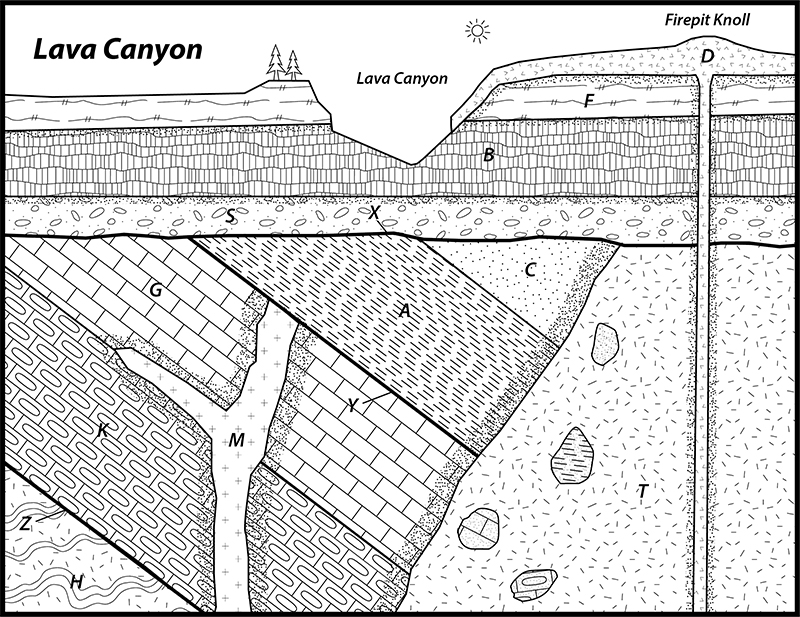

In [19]:
image_url = "https://physci.mesacc.edu/Geology/Leighty/GLG101IN/GLG101IN_Lab03_GeologicMaps/GLG101IN_Lab03_Fig23_LavaCanyonSequenceDiagram_800x617.jpg"
Image(image_url)

In [20]:
q = ("Which is older: T, A, M or X?"
     "Explain your reasoning but be brief.")
     # M.

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>In the provided geological cross-section, the principle of superposition and cross-cutting relationships can be used to determine the relative ages of the rock units.

- **T** is a sedimentary layer that lies above all the other layers, suggesting it is the youngest.
- **A** is a large, inclined layer that is cut by **X** and **M**, indicating it is older than both **X** and **M**.
- **M** is a vertical feature that cuts through **A**, suggesting it is younger than **A** but older than **T**.
- **X** is also a vertical feature that cuts through **A**, suggesting it is younger than **A** but older than **T**.

Based on this, **A** is the oldest among T, A, M, and X.

In [21]:
Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>To determine the relative ages of T, A, M, and X, we need to apply the principle of superposition, which states that in undisturbed rock layers, the oldest layers are at the bottom and the youngest at the top.

Looking at the image:

T is part of the surrounding rock that everything else seems to be intruding into.
A is an intrusive body cutting through several layers.
M is a vertical structure (likely a dike) cutting through other layers.
X is a layer that's cut by A and M.

Based on this:

T is the oldest, as it's the base rock that everything else is intruding into or deposited on.
X is younger than T but older than A and M, as it's cut by both.
A and M are the youngest features, as they cut through X.

Therefore, from oldest to youngest: T, X, then A and M (their relative age to each other is unclear from this cross-section).

In [22]:
Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>**A is the oldest.** Here's why:

* **Principle of Superposition:**  In undisturbed rock layers, the oldest layers are at the bottom. Layer A is beneath layers T, M, and X. 


# Photomicrograph: image analysis

The image of a Wolfville Formation (Jurassic) sandstone from Nova Scotia is licensed CC BY-SA by Michael C Rygel, and taken from the Wikipedia page on [lithic sandstone](https://en.wikipedia.org/wiki/Lithic_sandstone).

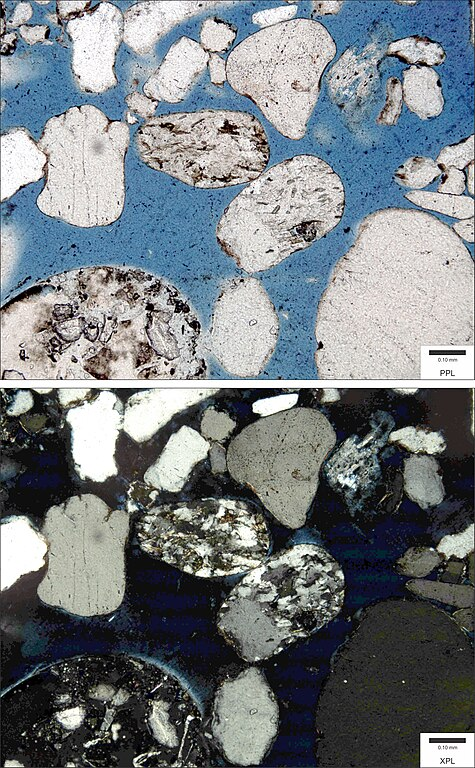

In [23]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Lithic-arenite.jpg/475px-Lithic-arenite.jpg"
Image(image_url)

We can do this with a little code, making it easy for ourselves by assuming that all the pixels with low red values are cement.

32.654293628808865


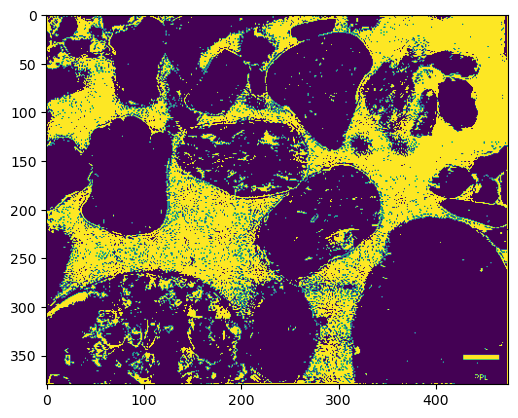

In [24]:
from PIL import Image as PILImage
import io
import numpy as np
import matplotlib.pyplot as plt

imb = httpx.get(image_url).content
image = PILImage.open(io.BytesIO(imb))
rgb = np.asarray(image)
mask = rgb[:380, :, 0] < 100
plt.imshow(mask)
print(100 * np.sum(mask) / mask.size)

In [25]:
q = ("What is the volume fraction of porosity?"
     "Explain your reasoning but be brief.")
     # About 33%

Markdown(
    ask_chatgpt(q, image_url)
)

**ChatGPT**<br/><hr/>The volume fraction of porosity can be estimated by examining the thin section images under both plane-polarized light (PPL) and cross-polarized light (XPL).

In these images, the blue areas represent the pore spaces (porosity) within the rock sample. To estimate the volume fraction of porosity, you can visually compare the proportion of blue areas (pores) to the total area of the image.

1. **Estimate the total area**: This includes both the solid grains and the pores.
2. **Estimate the area occupied by pores**: This is represented by the blue regions.

By comparing these areas, you can estimate the porosity. 

From the images provided, it appears that the blue areas (pores) occupy roughly 20-30% of the total area. Therefore, the volume fraction of porosity is approximately 20-30%.

This estimation is based on a visual assessment and can be more accurately determined using image analysis software or point counting methods in a laboratory setting.

In [26]:
Markdown(
    ask_claude(q, image_url)
)

**Claude**<br/><hr/>To estimate the volume fraction of porosity from these images, we need to look at the amount of blue space (in the top image) or dark space (in the bottom image) between the rock fragments.

The porosity appears to be relatively low in these samples. The rock fragments are closely packed, with only small spaces between them. Based on visual estimation:

1. The blue/dark areas (pore spaces) seem to occupy roughly 10-20% of the total area.
2. The white and gray rock fragments take up the majority of the space, around 80-90%.

Given this visual assessment, I would estimate the volume fraction of porosity to be approximately 0.15 or 15%.

This is a rough estimate based solely on the 2D cross-sections shown in the images. A more accurate measurement would require 3D analysis or laboratory testing of the actual rock sample.

In [27]:
Markdown(
    ask_gemini(q, image_url)
)

**Gemini**<br/><hr/>It is impossible to determine the volume fraction of porosity from a 2D image. 

Here's why:

* **Porosity is 3D:** Porosity represents the void space within a material, which exists in three dimensions. 
* **2D Images are Limited:**  A 2D image only shows a slice of the material. We can see areas that appear as pores, but we don't know how deep they go or how they connect in the third dimension.

**To calculate porosity accurately, we need a 3D representation of the material.** This could be obtained through methods like micro-CT scanning or serial sectioning. 


# Summary

| Image           | Question                       | ChatGPT        | Claude         | Gemini        |
|:----------------|:-------------------------------|:--------------:|:--------------:|:-------------:|
| Map             | Shale or limestone younger?    | 🔴             | 🔴             | 🟠            |
| Seismic         | Structural style?              | 🟢             | 🔴             | 🟠            |
| Core            | How much core?                 | 🟢             | 🔴             | 🔴            |
| Cross-section   | Which is the oldest?           | 🔴             | 🔴             | 🔴            |
| Thin section    | What is the porosity?          | 🟠             | 🟠             | 🔴            |

---
&copy; 2024 Matt Hall &mdash; licensed CC BY